In [4]:
import numpy as np
import matplotlib.pyplot as plt
from hyperion.model import ModelOutput
#from astropy.cosmology import Planck15                                                                     
from astropy import units as u
from astropy import constants
from decimal import Decimal
import prospect.io.read_results as pread

In [2]:
caesar_pos = np.load('/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/caesar_pos_radii.npz')

In [3]:
radii = caesar_pos['stellar_radius'][()]

In [4]:
sizes = []
for i in range(2463):
    sizes.append(radii['galaxy'+str(i)]['snap305'])

In [1]:
#0, 5, 20, 50, 80
galaxy='007'

In [2]:
run_old = '/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/snap305/snap305.galaxy'+galaxy+'.rtout.sed'

run_filtered = '/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/snap305_boxtest/snap305/snap305.galaxy'+galaxy+'.rtout.sed'

run_new = '/Volumes/ufrc/narayanan/s.lower/pd_runs/simba_m25n512/snap305_boxtest/snap305_fixedbox/snap305.galaxy'+galaxy+'.rtout.sed'

In [5]:
m_old = ModelOutput(run_old)
wavo,fluxo = m_old.get_sed(inclination='all',aperture=-1)
#except: print('error loading galaxy: ',sys.argv[2])                                                        
wavo  = np.asarray(wavo)*u.micron #wav is in micron                                                           
#wav *= (1.+z)                                                                                              

fluxo = np.asarray(fluxo)*u.erg/u.s
dlo = 10.0*u.pc
dlo = dlo.to(u.cm)


fluxo /= (4.*3.14*dlo**2.)

nuo = constants.c.cgs/(wavo.to(u.cm))
nuo = nuo.to(u.Hz)

fluxo /= nuo
fluxo = fluxo.to(u.mJy)

In [6]:
m = ModelOutput(run_new)
wav,flux = m.get_sed(inclination='all',aperture=-1)
#except: print('error loading galaxy: ',sys.argv[2])                                                        
wav  = np.asarray(wav)*u.micron #wav is in micron                                                           
#wav *= (1.+z)                                                                                              

flux = np.asarray(flux)*u.erg/u.s
dl = 10.0*u.pc
dl = dl.to(u.cm)


flux /= (4.*3.14*dl**2.)

nu = constants.c.cgs/(wav.to(u.cm))
nu = nu.to(u.Hz)

flux /= nu
flux = flux.to(u.mJy)

In [34]:
mf = ModelOutput(run_filtered)
wavf,fluxf = mf.get_sed(inclination='all',aperture=-1)
#except: print('error loading galaxy: ',sys.argv[2])                                                        
wavf  = np.asarray(wavf)*u.micron #wav is in micron                                                           
#wav *= (1.+z)                                                                                              
wavf = wavf.to(u.Angstrom)

fluxf = np.asarray(fluxf)*u.erg/u.s
dlf = 10.0*u.pc
dlf = dlf.to(u.cm)


fluxf /= (4.*3.14*dl**2.)

nuf = constants.c.cgs/(wavf.to(u.cm))
nuf = nuf.to(u.Hz)

fluxf /= nuf
fluxf = fluxf.to(u.mJy)
fluxf = (fluxf[0].value * 1000.) / 3631.

In [8]:
res, obs, mod = pread.results_from('/Volumes/ufrc/narayanan/s.lower/simSEDs/simbam25n512_newfof/snap305_nonparametricSFH/filtered_dirichlet/snap305.galaxy007_1562512336_mcmc.h5', dangerous=False)


In [9]:
imax = np.argmax(res['lnprobability'])
theta_best = res['chain'][imax, :].copy()


In [10]:
from prospect.sources import FastStepBasis
sps = FastStepBasis(compute_vega_mags=False, zcontinuous=1)

In [11]:
from prospect.models.templates import TemplateLibrary, adjust_dirichlet_agebins
from prospect.models import priors, SedModel
model_params = TemplateLibrary["dirichlet_sfh"]
model_params.update(TemplateLibrary["dust_emission"])

model_params["lumdist"] = {"N": 1, "isfree": False,
                               "init": 1.0e-5, "units":"Mpc"}
nbins = 10
tuniv = 13.7
tbinmax = (tuniv * 0.85)
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,tbinmax,nbins-2).tolist() + [tuniv]

model_params = adjust_dirichlet_agebins(model_params, agelims=(np.log10(agelims) + 9))

model_params['logzsol']['init'] = 0.0
model_params['logzsol']['prior'] = priors.TopHat(mini=-2.0, maxi=0.5)
model_params['mass']['prior'] = priors.TopHat(mini=1e7, maxi=1e13)
# Set the dust and agn emission free                                                                                                                                                                                                      
model_params["duste_qpah"]["isfree"] = True
model_params["duste_umin"]["isfree"] = True
model_params["duste_gamma"]["isfree"] = True
model_params['duste_gamma']['init'] = 0.1
model_params['duste_umin']['prior'] = priors.TopHat(mini=0.01, maxi=35)
model_params['duste_qpah']['prior'] = priors.TopHat(mini=0.01, maxi=5.0)
model_params["duste_gamma"]["prior"] = priors.TopHat(mini=1e-3, maxi=0.5)





# Complexify the dust attenuation                                                                                                                                                                                                         
model_params["dust_type"] = {"N": 1, "isfree": False, "init": 4, "units": "FSPS index"} #Conroy & Kriek dust atten.                                                                                                                       
model_params["dust2"]["prior"] = priors.TopHat(mini=0.0, maxi=4.0)
model_params["dust1"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "optical depth towards young stars",
                     "prior": priors.TopHat(mini=0.0, maxi=4.0)}
model_params["dust_index"] = {"N": 1, "isfree": True,
                     "init": 0.0, "units": "power-law multiplication of Calzetti",
                     "prior": priors.TopHat(mini=-2.5, maxi=0.7)}

# Now instantiate the model using this new dictionary of parameter specifications                                                                                                                                                         
model = SedModel(model_params)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  


In [12]:
spec, phot, mfrac = model.mean_model(theta_best, obs, sps)
wav = sps.wavelengths

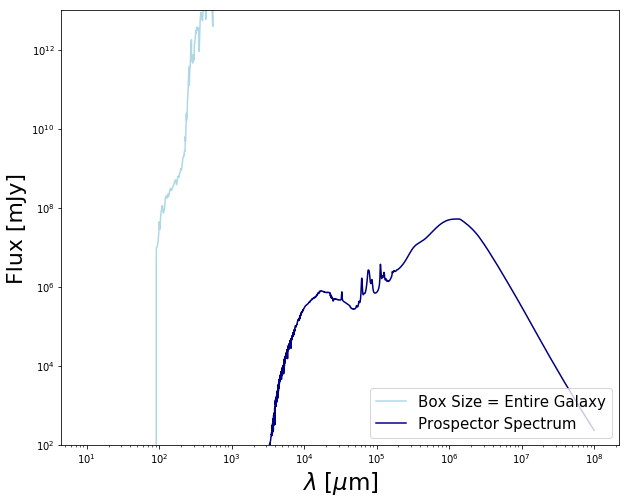

In [35]:
plt.figure(figsize=(10, 8))
#plt.plot(wavo, fluxo[0], color='navy', label='Box Size = 200kpc')
#plt.plot(wav, flux[0], color='orange', label='Box Size = 50 kpc')
plt.plot(wavf, fluxf, color='lightblue', label='Box Size = Entire Galaxy')
plt.plot(wav, spec, color='navy', label='Prospector Spectrum')
plt.xscale('log')
plt.yscale('log')
plt.ylabel('Flux [mJy]', fontsize=22)
plt.xlabel('$\lambda$ [$\mu$m]', fontsize=23)
plt.ylim([1e2, 1e13])
plt.legend(loc='lower right', fontsize=15)
#plt.annotate('Galaxy'+galaxy+'\n Size: '+"{:.1e}".format(Decimal(str(sizes[0])))+'kpc', xy=(1e-3, 1e15), fontsize=15)
#plt.savefig('/Users/sidneylower/Documents/snap305_boxtest/SED_comp'+galaxy+'.png')